In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import electricPotentialEnergy as pe

### Initialize the system

Initial Energy: 135.4876442697165


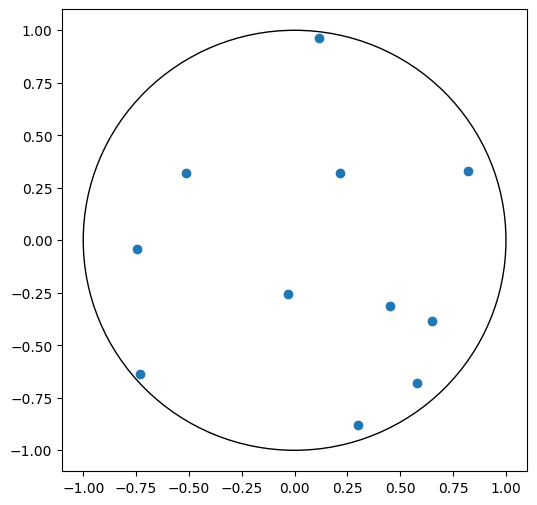

In [15]:
system = pe.Coulomb(11)

fig, ax = pe.plotState(system.state)
print(f"Initial Energy: {system.stateEnergy()}")

### Run Simulated Annealing

[135.48764427 135.48764427 132.89241989 ... 109.30631833 113.16077344
 109.12570567]
Final Energy: 97.83558568386957


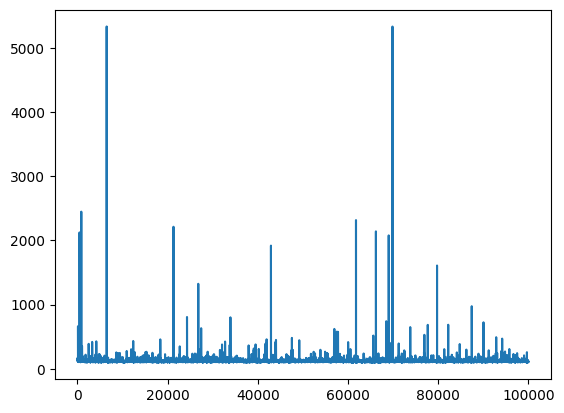

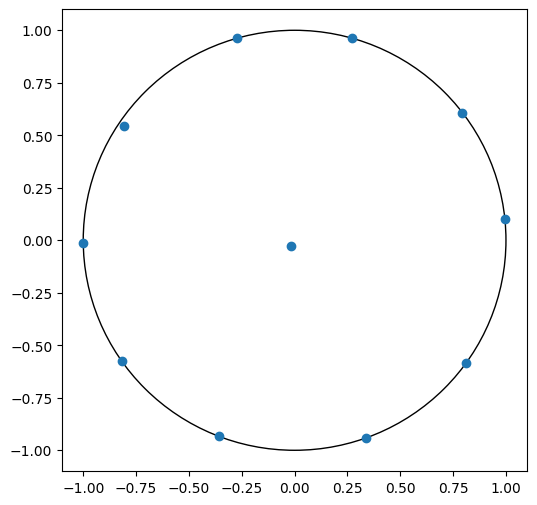

In [16]:
max_iters = 100000
initial_temp = 1000
cooling_rate = initial_temp / max_iters
max_step = 0.5

filename = "test"


scheme = pe.geometricCooling(initial_temp, 0.5)
optimized_system, energy = pe.simulatedAnnealing(system, 10, max_iters, scheme, max_step, save_path=filename)

plt.plot(energy)
print(energy)

fig, ax = pe.plotState(optimized_system.state)
print(f"Final Energy: {optimized_system.stateEnergy()}")
plt.show()

In [17]:
0/0

ZeroDivisionError: division by zero

### Load simulation results

In [ ]:
saved_states = np.load(f"{filename}.npy")

### Create animation using simulation results

MovieWriter ffmpeg unavailable; using Pillow instead.


ValueError: unknown file extension: .mp4

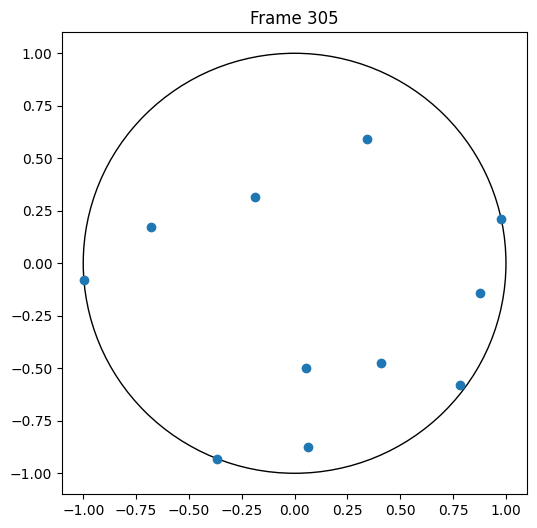

In [ ]:
def update(frame):
    """Update function for the animation."""
    pe.plotState(saved_states[frame], animation=True, ax=ax)
    ax.set_title(f"Frame {frame+1}")

fig, ax = plt.subplots(figsize=(6, 6))
ani = animation.FuncAnimation(fig, update, frames=len(saved_states), interval=200)

ani.save(f"{filename}.mp4", fps=50)